<a href="https://colab.research.google.com/github/Phillistan16/imoco_recon/blob/colab_demo/colab-imoco-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# iterative Motion Compensation (iMoCo) Reconstruction Demo
This CoLab notebook is a demo of the iMoCo method
https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.27998
https://github.com/PulmonaryMRI/imoco_recon


# Setup

<!-- By default, this colab notebook should have a GPU runtime environment. To check this, go to **Runtime > Change runtime type** and see if **GPU** is selected as **Hardware accelerator**. -->

To setup, we will install [SigPy](http://sigpy.readthedocs.io), [ANTs](https://github.com/ANTsX/ANTs) and clone the iMoCo github repo.

To activate GPU environment in Colab, go to Runtime -> Change Runtime -> GPU

In [1]:
# install dependent packages sigpy, antspy
!pip install sigpy==0.1.16
#!pip install antspyx # enable after moving from ANTs to [ANTsPy](https://github.com/ANTsX/ANTsPy)

# clone imoco recon repo
! git clone -b colab_demo https://github.com/PulmonaryMRI/imoco_recon

     |████████████████████████████████| 92kB 2.8MB/s 
Cloning into 'imoco_recon'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 149 (delta 55), reused 106 (delta 30), pack-reused 0
Receiving objects: 100% (149/149), 206.52 KiB | 3.38 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [2]:
# install ANTs
!git clone https://github.com/ANTsX/ANTs.git
!mkdir build install
%cd build
!cmake /content/ANTs
!make -j 2 2>&1
%cd ANTS-build
!make install 2>&1
import os
os.environ['PATH'] += ":/opt/ANTs/bin"
%cd ../..

Streaming output truncated to the last 5000 lines.
-- Installing: /content/build/staging/include/ITK-5.1/itkClassifierBase.h
-- Installing: /content/build/staging/include/ITK-5.1/itkImageModelEstimatorBase.h
-- Installing: /content/build/staging/include/ITK-5.1/itkScalarImageKmeansImageFilter.h
-- Installing: /content/build/staging/include/ITK-5.1/itkBayesianClassifierInitializationImageFilter.h
-- Installing: /content/build/staging/include/ITK-5.1/itkImageGaussianModelEstimator.h
-- Installing: /content/build/staging/include/ITK-5.1/itkImageModelEstimatorBase.hxx
-- Installing: /content/build/staging/include/ITK-5.1/itkBayesianClassifierImageFilter.h
-- Installing: /content/build/staging/include/ITK-5.1/itkImageGaussianModelEstimator.hxx
-- Installing: /content/build/staging/include/ITK-5.1/itkClassifierBase.hxx
-- Installing: /content/build/staging/include/ITK-5.1/itkImageKmeansModelEstimator.h
-- Installing: /content/build/staging/include/ITK-5.1/itkScalarImageKmeansImageFilter.hxx


In [3]:
# import packages
import imoco_recon.imoco_py.sigpy_e.cfl as cfl
import numpy as np
import sigpy.plot as pl

# Download dataset

Now, let's download a sample Lung UTE dataset. The dataset is hosted on Zenodo: https://zenodo.org/record/3733776#.XoJlNC2ZPOQ.

<!-- The `download_lung_dataset()` function will download the datasets if it cannot find them under `data/lung/`. It takes around 8 minutes to download the datasets. -->

In [4]:
!mkdir lung_mri
!pip install zenodo-get
!zenodo_get -d 10.5281/zenodo.3733775 -o ./lung_mri

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=e48ea730abb1228c36bd707a08f237e40524099e29c230881869afb94cda8707
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Title: Free Breathing Lung MRI Dataset at 3T
Keywords: lung MRI, motion correction
Publication date: 2020-03-30
DOI: 10.5281/zenodo.3733776
Total size: 4800.4 MB

Link: https://zenodo.org/api/files/4e2fa077-5616-489c-b70f-3464b7f2ec44/cfl.py   size: 0.0 MB

Checksum is correct. (54d868ad54b8a2b35606d5771f53c0e0)

Link: https://zenodo.org/api/files/4e2fa077-5616-489c-b70f-3464b7f2ec44/MRI_Raw_datam.cfl   size: 3074.7 MB

Checksum is correct. (ec2e8d5f885147873ce386d99dc90343)

Link: https://zenodo.org/api/files/4e2fa077-5616-489c-b70f-3464b7f2ec44/MRI_Raw_datam.hdr   size: 0.0 MB

Checksum is correct. (f2bf52eb84dd2bc8299c8f058306b765)

Link: https://zenodo.org/api/files/4e2fa077-5616-489c-b70f-3464b7f2ec44/MRI_Raw_d

# Crop Data (Optional)
decrease number of frequency encoding points to adapt for Colab RAM

In [16]:
num_ro = 200

datam = cfl.read_cfl('./lung_mri/MRI_Raw_datam')
datam = datam[:,:,:,:,:num_ro,:]
cfl.write_cfl('./lung_mri/MRI_Raw_datam', datam)

In [17]:
dcf2m = cfl.read_cfl('./lung_mri/MRI_Raw_dcf2m')
dcf2m = dcf2m[:,:,:,:,:num_ro,:]
cfl.write_cfl('./lung_mri/MRI_Raw_dcf2m', dcf2m)

In [18]:
trajm = cfl.read_cfl('./lung_mri/MRI_Raw_trajm')
trajm = trajm[:,:,:,:,:num_ro,:]
cfl.write_cfl('./lung_mri/MRI_Raw_trajm', trajm)

In [19]:
# release RAM
del datam
del dcf2m
del trajm

# iMoCo Reconstruction

## step 1. XD-GRASP, motion-resolved reconstruction 
## step 2. iMoCo reconstruction

When running iMoCo for the first time, use flag --reg_flag 1, which generates the motion field needed for iMoCo reconstruction 

If the motion field exists already (e.g. from previous iMoco recon), no flag is needed

In [20]:
# xd-grasp recon
!python imoco_recon/imoco_py/recon_xdgrasp.py ./lung_mri/MRI_Raw --device 0

JsenseRecon: 100% 10/10 [00:15<00:00,  1.52s/it]
outer iter:0, res:1.0
outer iter:1, res:0.6153555512428284
outer iter:2, res:0.4152965843677521
outer iter:3, res:0.2897503972053528
outer iter:4, res:0.20213954150676727
outer iter:5, res:0.13695521652698517
outer iter:6, res:0.08666440844535828
outer iter:7, res:0.04738427698612213
outer iter:8, res:0.017541415989398956
outer iter:9, res:0.010017949156463146
outer iter:10, res:0.024471217766404152
outer iter:11, res:0.03403307497501373
outer iter:12, res:0.037935711443424225
outer iter:13, res:0.03687838092446327
outer iter:14, res:0.03199930116534233
outer iter:15, res:0.024720804765820503
outer iter:16, res:0.016543323174118996
outer iter:17, res:0.008854111656546593
outer iter:18, res:0.003330372041091323
outer iter:19, res:0.004226641729474068


In [21]:
# imoco recon with motion field derivation
!python imoco_recon/imoco_py/recon_imoco.py ./lung_mri/MRI_Raw --reg_flag 1 --device 0

Calibration...
JsenseRecon: 100% 10/10 [00:11<00:00,  1.16s/it]
Registration...
All_Command_lines_OK
Using double precision for computations.
  number of levels = 3
  fixed image: tmp_Im.nii
  moving image: tmp_If.nii
Dimension = 3
Number of stages = 1
Use Histogram Matching true
Winsorize image intensities true
Lower quantile = 0.1
Upper quantile = 1
Stage 1 State
   Image metric = Demons
     Fixed image = Image (0x55729c496000)
  RTTI typeinfo:   itk::Image<double, 3u>
  Reference Count: 2
  Modified Time: 722
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 0
  UpdateMTime: 508
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [140, 93, 95]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [140, 93, 95]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [140, 93, 

# Plot
plot the motion-resolved image and the iMoCo reconstructed image

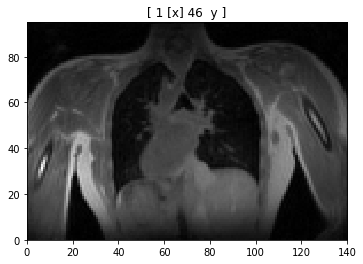

In [22]:
# plot motion-resolved mrL image
mrL = cfl.read_cfl('lung_mri/MRI_Raw_mrL')
pl.ImagePlot(mrL, x = -3, y = -1)

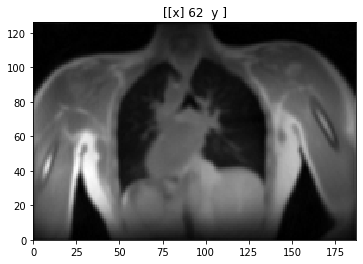

In [23]:
# plot iMoCo image
imoco = cfl.read_cfl('lung_mri/MRI_Raw_imoco')
pl.ImagePlot(imoco, x = -3, y = -1)